# **Clasificación del sexismo en comentarios**

**Descripción del problema**

El uso de un leguaje sexista se manifiesta de diversas formas, y muchas veces lo empleamos sin ser totalmente concientes de ello. Sin embargo, sus consecuencias sociales son muy importantes, ya que contribuye a perpetuar las desigualdades de género entre hombres y mujeres. Además, el leguale sexista crea ambiguedad y confusión en los mensajes o comentarios que intentamos transmitir, especialmente en el contexto de las redes sociales, donde los comentarios pueden ser malinterpretados, afectando la percepción pública y las relaciones entre individuos.
Este tipo de lenguaje socava el progreso hacia una sociedad más equitativa y repetuosa. En plataformas digitales, los comentarios sexistas pueden ir desde actitudes despectivas hasta amenazas directas, lo que contribuye a un ambiente tóxico y peligroso para muchas personas. La clasificación de comentarios sexistas es esencial para mitigar este tipo de comentarios.

Este trabajo tiene como objetivo entrenar un modelo de aprendizaje supervisado capaz de clasificar en 4 categorias comentarios sexistas.

Para llevar a cabo esta tarea, utilizamos el siguiente conjunto de datos de Kaggle que contiene ejemplos de comentarios etiquetados como sexistas y no sexistas.

https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts/data

**Variables del conjunto de datos**

El conjunto de datos contiene 6 columnas que son:

1.   rewire_id: Identificador único de cada comentario.
2.   text: Esta columna contiene los comentarios en ingles.

3.   label_sexist: Esta columna indica si el comentario es sexista o no sexista con valores como "sexist" y "not sexist".
4.   label_category: Contiene categorías especificas dentro de los comentarios sexistas. Cada categoría representa un tipo particular de sexismo, como "amenazas, planes de daño e incitación", "humillación", "animosidad", o "discusiones prejuiciosas".

5.   label_vector: representa una subcategoría, para detallar más la categorías.
6.   split: indica la división de los datos (train o test).







# **Librerías utilizadas**

In [ ]:
#Manipulación y análisis de datos
import pandas as pd
import numpy as np

#Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Preprocesado y modelado
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from s upklearn.neural_network import MLPClassifier
from s itklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#Evaluación del modelo
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Tratamiento de datos
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#Descargar stopwors y lematizador
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter

# Configuración warnings
import warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Para la carga del conjunto de datos que se encuentra en un archivo CSV, se utiliza una función de la librería de pandas que nos devuelve un DataFrame. Con la función info de pandas generamos un informe de los datos que el archivo contiene. También eliminamos lo comentarios que no son sexistas para trabajar únicamente con los datos relevantes del objetivo.

In [ ]:
#Carga de datos
datos = pd.read_csv("/content/train (2).csv")
prueba = pd.read_csv("/content/test (1).csv")
#Eliminación de comentarios no sexistas
datos = datos[datos["label_sexist"] != "not sexist"]
prueba = prueba[prueba["label_sexist"] != "not sexist"]
#Eliminación de las columnas irrelevantes
datos = datos.drop(columns=['label_vector', 'split', 'label_sexist','rewire_id'])
prueba = prueba.drop(columns=['label_vector', 'split', 'label_sexist','rewire_id'])
#Información de los datos de entrenamiento
datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 4 to 13993
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            3398 non-null   object
 1   label_category  3398 non-null   object
dtypes: object(2)
memory usage: 79.6+ KB


In [ ]:
#Información de los datos de prueba
prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 1 to 3999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            970 non-null    object
 1   label_category  970 non-null    object
dtypes: object(2)
memory usage: 22.7+ KB


Eliminamos las columnas rewire_id, label_vector y split para que no interrumpan el desarrollo de nuestro modelo.

In [ ]:
#Visualización de los primero 10 ejemplos de los datos de entrenamiento
datos.head(10)

,text,label_category
4,[USER] Leg day is easy. Hot girls who wear min...,3. animosity
6,I get a new pussy every other week or whenever...,2. derogation
11,O come on there's no way any men are attracted...,2. derogation
21,Former BBC journalist Thuto Mali says that uni...,4. prejudiced discussions
25,I did. You have to have the bravery to escalat...,"1. threats, plans to harm and incitement"
31,"Not going to lie, the brutal honesty of this r...",4. prejudiced discussions
33,"Please.... take my wife, rape my daughter!! Bu...","1. threats, plans to harm and incitement"
34,Pink is very feminine so I accept this bikini ...,3. animosity
38,"Yes. Especially these days, it takes a lot to ...","1. threats, plans to harm and incitement"
39,Put a fork in Muslim-England she's done for an...,3. animosity


Verificación de datos faltantes

In [ ]:
#Verificamos si hay datos faltantes
datos.isnull().sum()

,0
text,0
label_category,0


In [ ]:
prueba.isnull().sum()

,0
text,0
label_category,0


Observamos que no hay datos faltantes

En este caso, no generaremos un resumen estadístico, ya que consideramos que no es útil porque el dataset es principalmente de tipo texto. El conjunto de datos consiste en 4 clases, etiquetadas como 1. amenazas, planes de daño e incitación, 2. humillación, 3. animosidad y 4. discusiones prejuiciosas

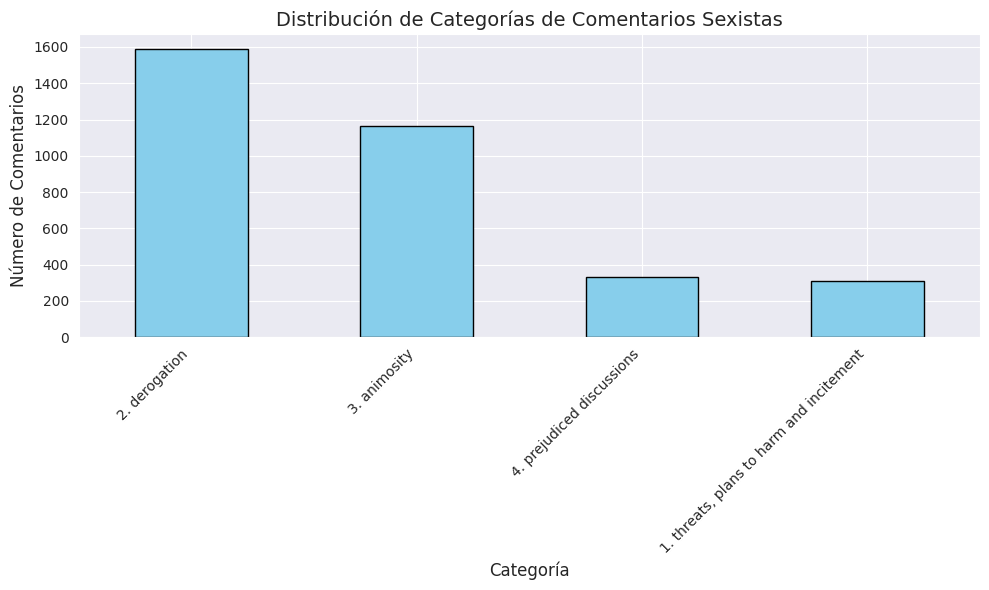

In [ ]:
#Grafico de barras
# Configuración de estilo
sns.set_style("darkgrid")

# Agrupar por categoría y contar la frecuencia
category_counts = datos['label_category'].value_counts()

# Gráfico de barras para las categorías de comentarios sexistas
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de Categorías de Comentarios Sexistas', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de Comentarios', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Se puede observar que hay un desbalance entre las clases, ya que "humillación" y "animosidad" tiene muchos más ejemplos que "amenazas, planes de daño e incitación" y "discuciones prejuiciosas". Este desbalance podría afectar el modelo, ya que puede que tenga más facilidad para identificar las clases que tienen mas ejemplos y menor precisión para las otras clases.

# Nube de palabras

Nube de palabras de los comentarios sin preprocesar.

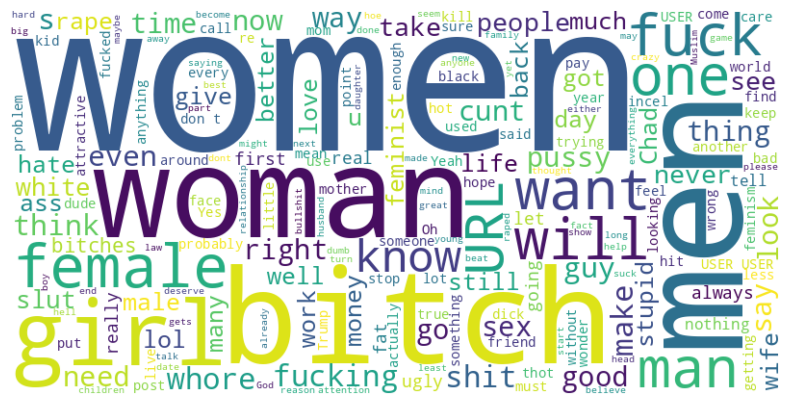

In [ ]:
# Concatenar todos los textos en un solo string
text = " ".join(datos['text'].dropna())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la imagen de la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.show()



# **Limpieza de datos**🧹

Para la limpieza de los datos realizamos las siguientes tareas:



*   Convertir el texto a minúscula.
*   Eliminación de signos de puntuación.
*   Eliminación de URLs.
*   Eliminación de numeros.
*   Eliminación de menciones y hashtags.
*   Eliminación de caracteres no alfabéticos.
*   Eliminación de fracciones.
*   Eliminación de fechas.
*   Eliminación de stopwords.

también se tokeniza el texto y se aplica lemmatización.











In [ ]:
#Instacia del lematizador
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #Conversión a minúsculas
    new_text = text.lower()

    #Eliminación de URLs
    new_text = re.sub(r'https?://\S+|www\.\S+', '', new_text)

    #Eliminación de meciones y hashtags
    new_text = re.sub(r'@\S+|#\S+', '', new_text)

    #Eliminación de números
    new_text = re.sub(r'\d+', '', new_text)

    #Eliminación de caracteres no alfabéticos
    new_text = re.sub(r'[^a-zA-Z\s]', '', new_text)

    #Eliminación de fechas
    new_text = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', '', new_text)

    #Tokenizarción del texto
    words = new_text.split()

    #Eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    #Lemmatización
    words = [lemmatizer.lemmatize(word) for word in words]

    #Eliminación de palabras con longitud < 2
    words = [word for word in words if len(word) > 1]
    #Unión de palabras
    new_text = ' '.join(words)

    return new_text

In [ ]:
#Limpieza al conjunto de entrenamiento
datos = datos.copy()
datos.loc[:,'cleaned_text'] = datos['text'].apply(clean_text)
datos['category_number'] = datos['label_category'].str.extract(r'(\d+)').astype(int)
datos['category_text'] = datos['label_category'].str.replace(r'^\d+\.\s*', '', regex=True)
datos.head(10)

,text,label_category,cleaned_text,category_number,category_text
4,[USER] Leg day is easy. Hot girls who wear min...,3. animosity,user leg day easy hot girl wear miniskirt get ...,3,animosity
6,I get a new pussy every other week or whenever...,2. derogation,get new pussy every week whenever want really ...,2,derogation
11,O come on there's no way any men are attracted...,2. derogation,come there way men attracted shes pig,2,derogation
21,Former BBC journalist Thuto Mali says that uni...,4. prejudiced discussions,former bbc journalist thuto mali say universal...,4,prejudiced discussions
25,I did. You have to have the bravery to escalat...,"1. threats, plans to harm and incitement",bravery escalate touch boob etc work escalating,1,"threats, plans to harm and incitement"
31,"Not going to lie, the brutal honesty of this r...",4. prejudiced discussions,going lie brutal honesty reply got rolling hah...,4,prejudiced discussions
33,"Please.... take my wife, rape my daughter!! Bu...","1. threats, plans to harm and incitement",please take wife rape daughter whatever leave ...,1,"threats, plans to harm and incitement"
34,Pink is very feminine so I accept this bikini ...,3. animosity,pink feminine accept bikini babe youve paid due,3,animosity
38,"Yes. Especially these days, it takes a lot to ...","1. threats, plans to harm and incitement",yes especially day take lot make man beat woma...,1,"threats, plans to harm and incitement"
39,Put a fork in Muslim-England she's done for an...,3. animosity,put fork muslimengland shes done saving going ...,3,animosity


In [ ]:
#Limpieza al conjunto de entrenamiento
prueba = prueba.copy()
prueba.loc[:,'cleaned_text'] = prueba['text'].apply(clean_text)
prueba['category_number'] = prueba['label_category'].str.extract(r'(\d+)').astype(int)
prueba['category_text'] = prueba['label_category'].str.replace(r'^\d+\.\s*', '', regex=True)
prueba.head(10)

,text,label_category,cleaned_text,category_number,category_text
1,Well then good because someone has to knock he...,2. derogation,well good someone knock as back line act like ...,2,derogation
3,"Yes, normal women want to be dominated. Social...",2. derogation,yes normal woman want dominated social scienti...,2,derogation
4,She didn't have to be a bitch about it. She li...,2. derogation,didnt bitch literally went way rub rejection f...,2,derogation
9,Just fucking lol. What does she know about a h...,2. derogation,fucking lol know hard life subhuman dumb whore,2,derogation
11,I would pay to see her Ass Cracker. #nsfw,2. derogation,would pay see as cracker,2,derogation
25,LOL that fat girl .... black men cant catch up...,3. animosity,lol fat girl black men cant catch angry sooo b...,3,animosity
26,"If you don't want your mother fucked, keep her...",2. derogation,dont want mother fucked keep street,2,derogation
29,10/10 with interior decorating skills like you...,3. animosity,interior decorating skill like girl falling im...,3,animosity
41,Isn't it convenient that she doesn't have the ...,4. prejudiced discussions,isnt convenient doesnt video guy threatening k...,4,prejudiced discussions
44,"Yes, it is new. What remains constant is that ...",4. prejudiced discussions,yes new remains constant feminist playing fear...,4,prejudiced discussions


Se realiza la limpieza de los datos y también se separa el numero de cada categoría.

Verificamos nuevamente si hay valores nulos

In [ ]:
datos.isnull().sum()

,0
text,0
label_category,0
cleaned_text,0
category_number,0
category_text,0


In [ ]:
prueba.isnull().sum()

,0
text,0
label_category,0
cleaned_text,0
category_number,0
category_text,0


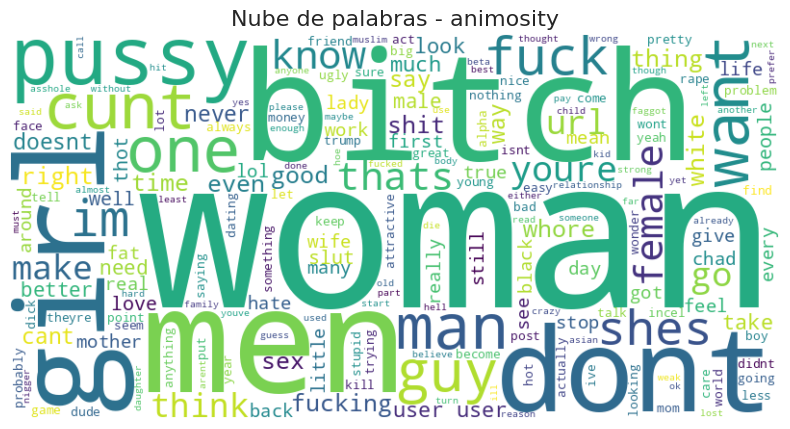

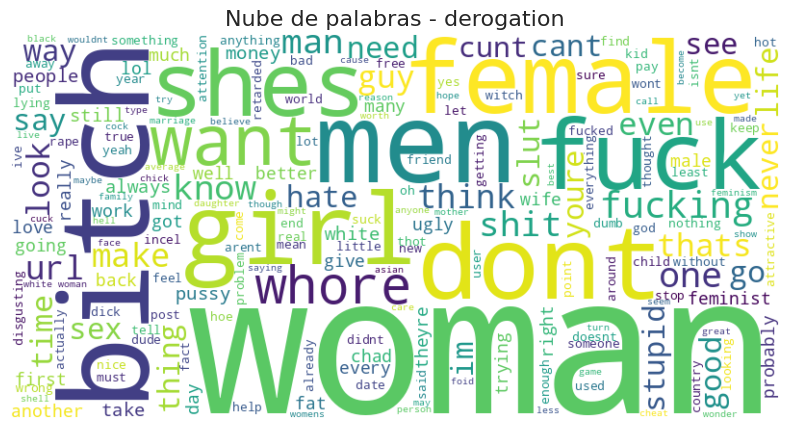

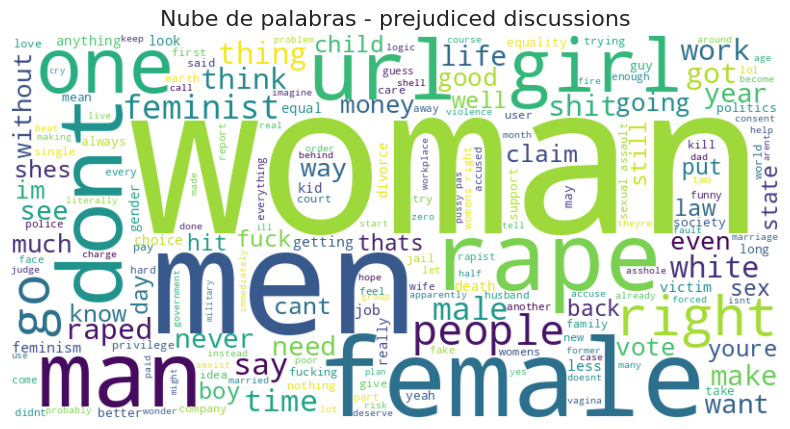

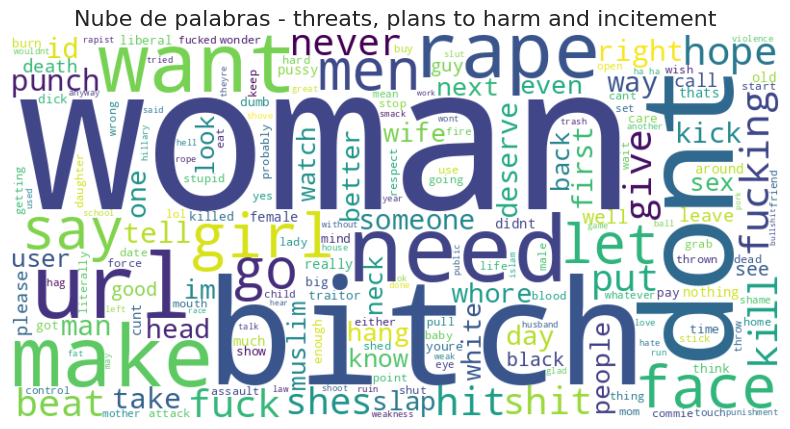

In [ ]:
categorias = datos['category_text'].unique()

# Crear una nube de palabras para cada categoría
for category in categorias:
    category_text = " ".join(
        comentario for comentario in datos[datos['category_text'] == category]['cleaned_text']
    )

    # Crear la nube de palabras
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=200,
                          contour_color='steelblue',
                          contour_width=1,
                          ).generate(category_text)

    # Mostrar la imagen de la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nube de palabras - {category}", fontsize=16)
    plt.show()

Podemos observar que palabras como 'woman', 'men' y 'girl' se repiten en todas las categorías. Estas palabras podrían no aportar mucho en la clasificación, ya que son demasiado comunes. También hay palabras que parecen ser irrelevantes para la clasificación, como 'url' y 'user'.

A continuación haremos un recuento de las palabras por categoría.

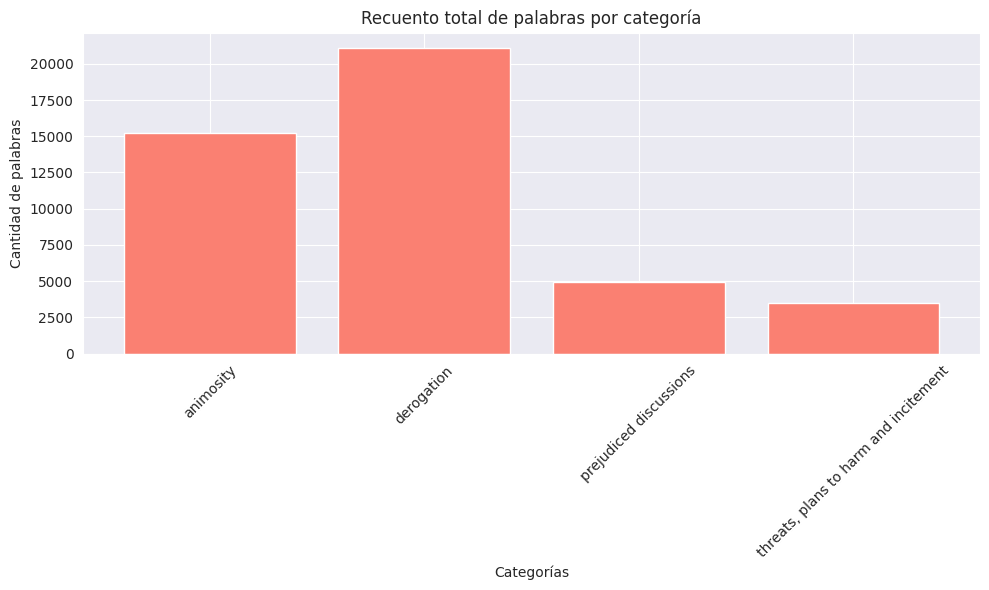

{'animosity': 15249, 'derogation': 21081, 'prejudiced discussions': 4952, 'threats, plans to harm and incitement': 3528}


In [ ]:
# Calcular el total de palabras por categoría
def total_word_count_by_category(df, text_column, label_column):
    word_count_by_category = {}
    for category in df[label_column].unique():
        # Concatenar todas las palabras de la categoría y contar
        all_words = ' '.join(df[df[label_column] == category][text_column]).split()
        word_count_by_category[category] = len(all_words)
    return word_count_by_category

# Obtener el recuento total de palabras por categoría
word_count = total_word_count_by_category(datos, 'cleaned_text', 'category_text')

# Graficar el recuento total de palabras por categoría
def plot_total_word_count(word_count):
    categories = list(word_count.keys())
    counts = list(word_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='salmon')
    plt.title("Recuento total de palabras por categoría")
    plt.xlabel("Categorías")
    plt.ylabel("Cantidad de palabras")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_total_word_count(word_count)
print(word_count)


Notamos que "derogation" y "animosity" tienen el mayor número de palabras esto puede generar que estas categorías tengan una mayor influencia en el modelo, en cambio, las categorias con menos palabras podria generar problemas al modelo para clasificarlas correctamente.

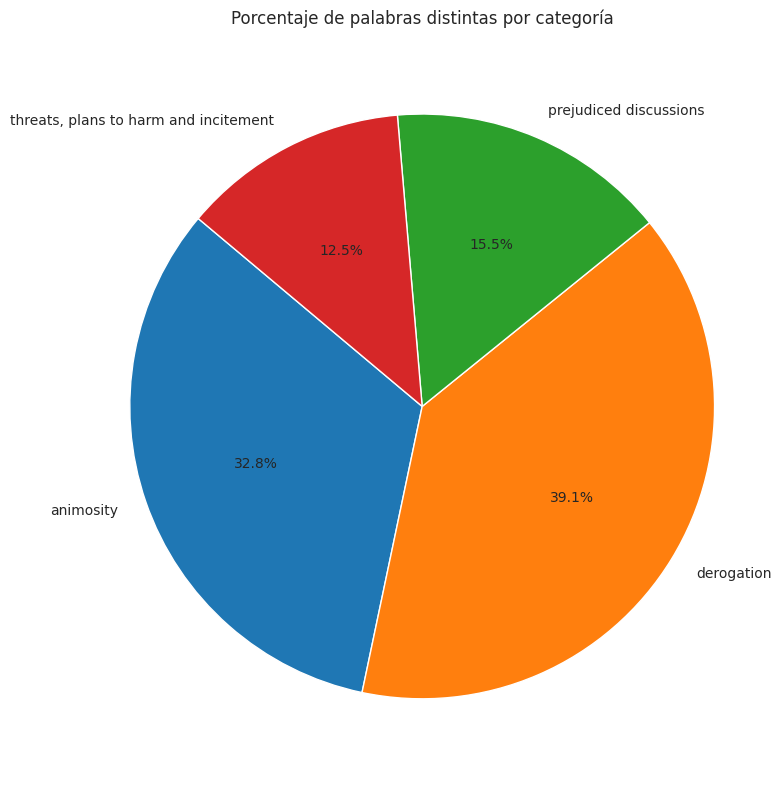

In [ ]:
# Calcular palabras distintas por categoría
def distinct_word_count_by_category(df, text_column, label_column):
    distinct_word_count = {}
    for category in df[label_column].unique():
        # Obtener todas las palabras únicas en la categoría
        all_words = ' '.join(df[df[label_column] == category][text_column]).split()
        distinct_word_count[category] = len(set(all_words))
    return distinct_word_count

# Obtener el recuento de palabras distintas por categoría
distinct_word_count = distinct_word_count_by_category(datos, 'cleaned_text', 'category_text')

# Graficar el diagrama de pastel
def plot_pie_chart(distinct_word_count):
    labels = list(distinct_word_count.keys())
    sizes = list(distinct_word_count.values())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
    plt.title("Porcentaje de palabras distintas por categoría")
    plt.axis('equal')  # Asegurar que el gráfico sea un círculo
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_pie_chart(distinct_word_count)


"threats, plans to harm and incitement" y "prejudiced discussions" tienen una baja representación de palabras distintas.

In [ ]:
# Calcular palabras comunes entre categorías
def common_words_between_categories(df, text_column, label_column):
    # Crear un conjunto para cada categoría
    category_word_sets = {
        category: set(' '.join(df[df[label_column] == category][text_column]).split())
        for category in df[label_column].unique()
    }

    # Calcular la intersección de todos los conjuntos de palabras
    common_words = set.intersection(*category_word_sets.values())
    return common_words

# Obtener las palabras comunes entre categorías
common_words = common_words_between_categories(datos, 'cleaned_text', 'category_text')

# Mostrar el recuento de palabras comunes
print(f"Número total de palabras comunes entre todas las categorías: {len(common_words)}")
print("Palabras comunes:", common_words)

Número total de palabras comunes entre todas las categorías: 591
Palabras comunes: {'teen', 'push', 'dont', 'feed', 'said', 'someone', 'sometimes', 'ago', 'owned', 'going', 'strong', 'something', 'sweet', 'men', 'attention', 'class', 'case', 'sentence', 'violence', 'pregnant', 'ill', 'alone', 'liberal', 'count', 'become', 'nail', 'tell', 'crime', 'back', 'several', 'worked', 'nigger', 'thank', 'dick', 'spoiled', 'live', 'leader', 'kill', 'everyone', 'already', 'happening', 'scared', 'old', 'equal', 'feminist', 'honestly', 'cannot', 'put', 'funny', 'new', 'wonder', 'without', 'learn', 'twitter', 'consent', 'marriage', 'line', 'high', 'equality', 'language', 'hell', 'cause', 'buy', 'much', 'less', 'prison', 'self', 'dollar', 'make', 'sick', 'advantage', 'attractive', 'air', 'pic', 'front', 'gf', 'race', 'mother', 'try', 'send', 'suck', 'fair', 'stay', 'many', 'sex', 'literally', 'socalled', 'he', 'doubt', 'hillary', 'though', 'response', 'plan', 'happy', 'wait', 'pathetic', 'ever', 'gym'

Estas son la palabras que aparecen frecuentemente en todos los comentarios y pueden no aportar información relevante para la clasificación.

Nube de las palabras más comunes.

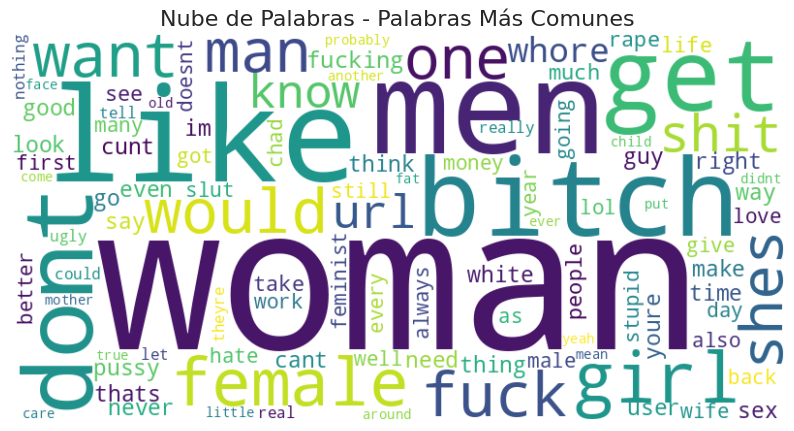

In [ ]:
# Crear una nube de palabras a partir de las palabras más comunes
def generate_wordcloud(df, text_column, max_words=100):
    # Concatenar todos los textos
    all_words = ' '.join(df[text_column]).split()
    word_counts = Counter(all_words)

    # Crear la nube de palabras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=max_words
    ).generate_from_frequencies(word_counts)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nube de Palabras - Palabras Más Comunes", fontsize=16)
    plt.show()

# Generar la nube de palabras
generate_wordcloud(datos, 'cleaned_text', max_words=100)



# VECTORIZACIÓN Y TRATAMIENTO DE LOS DATOS


**Vectorización del texto con Bag of Wors (BOW)**

Convertimos el texto limpio en una representación numérica que el modelo puede utilizar. El enfoque que estamos utilizando representa cada comentario como un vector de característica. Cada dimesión del vector corresponde a una palabra del conjunto de datos, y el valor de esa dimensión es el numéro de veces que aparece esa palabra en el documento.

Parametros de CountVectorizer



*   min_df: cosidermos solo las palabras que aparecen al menos 5 veces en el conjunto de datos.
*   max_df: e



In [ ]:
# Vectorización BOW
vectorizer = CountVectorizer(min_df=5, max_df=0.95)

X_train = vectorizer.fit_transform(datos['cleaned_text'])
X_test = vectorizer.transform(prueba['cleaned_text'])

# Ver palabras clave y su mapeo en el vectorizador
print(vectorizer.get_feature_names_out())

# Mostrar el tamaño del resultado de la transformación
datos['X'] = list(X_train.toarray())  # Para poder ver las características vectorizadas

print(datos[['text', 'cleaned_text']].head())

print(X_train.shape)

['ability' 'able' 'abortion' ... 'youve' 'yup' 'zero']
                                                 text  \
4   [USER] Leg day is easy. Hot girls who wear min...   
6   I get a new pussy every other week or whenever...   
11  O come on there's no way any men are attracted...   
21  Former BBC journalist Thuto Mali says that uni...   
25  I did. You have to have the bravery to escalat...   

                                         cleaned_text  
4   user leg day easy hot girl wear miniskirt get ...  
6   get new pussy every week whenever want really ...  
11              come there way men attracted shes pig  
21  former bbc journalist thuto mali say universal...  
25    bravery escalate touch boob etc work escalating  
(3398, 1468)


Se realiza la codificación de las variables de categoria a numeros.
Como ya tenemos un dataframe con solo datos de prueba, esta codificación representa los datos (sin procesar) de prueba para los modelos.

In [ ]:
# Dividir los datos en entrenamiento y prueba
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(datos['label_category'])
y_test = label_encoder.transform(prueba['label_category'])

print(y_train)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

[2 1 1 ... 2 1 1]
{0: 310, 1: 1590, 2: 1165, 3: 333}


Como tenemos datos muy desbalanceados Utilizamos SMOTE (Synthetic Minority Oversampling Technique) para darle más representación a las clases minoritarias. Debido a que nuestro conjunto de datos tiene un distribución desigual entre las clases, los modelos tienden a predecir más la clase mayoritaria.
SMOTE genera ejemplos sintéticos de las clases minoritarias a partir de los ejemplos existentes.

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test,y_test)

Utlizando Random Forest, clasificamos las caracteristicas y obtenemos las más importantes, seleccionando las 1000 más importantes para un nuevo set de datos de entrenamiento y prueba.

In [ ]:
# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=200,min_samples_split=5)
rf.fit(X_train_resampled, y_train_resampled)

# Obtener la importancia de las características
importancias = rf.feature_importances_

# Seleccionar las características más importantes
indices = np.argsort(importancias)[::-1]  # Ordenar de mayor a menor
X_train_selected = X_train_resampled[:, indices[:1000]]  # Seleccionar las 1000 más importantes
X_test_selected = X_test_resampled[:, indices[:1000]]  # Seleccionar las 1000 más importantes

print(X_train_selected)

  (0, 33)	1
  (0, 443)	1
  (0, 50)	1
  (0, 246)	1
  (0, 211)	1
  (0, 8)	1
  (0, 571)	1
  (0, 9)	1
  (1, 9)	3
  (1, 386)	1
  (1, 5)	1
  (1, 98)	1
  (1, 630)	1
  (1, 22)	1
  (1, 100)	1
  (1, 185)	1
  (1, 462)	1
  (1, 241)	1
  (1, 572)	1
  (1, 91)	1
  (1, 10)	1
  (1, 660)	1
  (1, 78)	1
  (1, 265)	1
  (1, 70)	1
  :	:
  (6357, 191)	0
  (6358, 159)	0
  (6358, 153)	0
  (6358, 614)	0
  (6358, 559)	0
  (6358, 2)	1
  (6358, 250)	0
  (6358, 860)	0
  (6358, 212)	0
  (6358, 378)	0
  (6358, 214)	0
  (6359, 826)	0
  (6359, 171)	0
  (6359, 8)	0
  (6359, 403)	0
  (6359, 232)	0
  (6359, 723)	0
  (6359, 4)	1
  (6359, 839)	0
  (6359, 77)	0
  (6359, 46)	0
  (6359, 524)	0
  (6359, 208)	0
  (6359, 24)	0
  (6359, 0)	1


# CREACIÓN Y ENTRENAMIENTO DE LOS MODELOS 💻

Una vez hemos preprocesado los datos de entrenamiento y prueba, crearemos los modelos de IA y los entrenaremos para poder comparar sus resultados, de los modelos que entrenaremos tenemos:

1.   Regresión logistica y softMax (LogisticRegression)
2.   arboles de desición (DecisionTreeClassifier)
3. Random Forest (RandomForestClassifier)
4. Redes neuronales (MLPClassifier)

Utilizaremos los datos de entrenamiento en sus distintas etapas (inicial, después de oversampling, y después de selección)

Posteriormente, variaremos parametros para realzar más pruebas.

# REGRESIÓN 📈

Regresión con datos sin procesar

---



Modelo de Regresión Logística - Accuracy: 0.477319587628866
              precision    recall  f1-score   support

           0       0.45      0.27      0.34        89
           1       0.52      0.61      0.56       454
           2       0.42      0.41      0.41       333
           3       0.42      0.30      0.35        94

    accuracy                           0.48       970
   macro avg       0.45      0.40      0.42       970
weighted avg       0.47      0.48      0.47       970



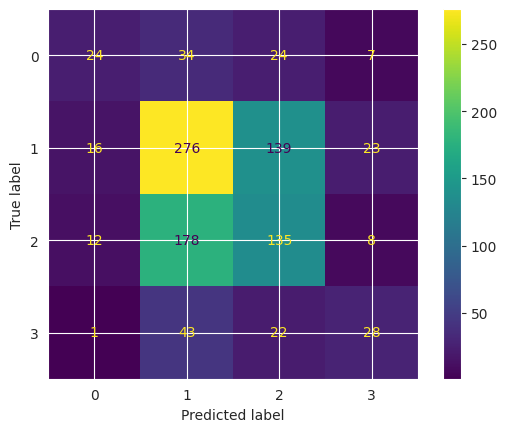

In [ ]:
# Crear y entrenar el modelo de regresión logística
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

# Evaluar el modelo
predictions_logistic = model_logistic.predict(X_test)
print("Modelo de Regresión Logística - Accuracy:", accuracy_score(y_test, predictions_logistic))
print(classification_report(y_test, predictions_logistic))

#matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions_logistic)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_logistic.classes_).plot()

Regresión logistica después de SMOTE

---



Modelo de Regresión Logística - Accuracy: 0.5308370044052864
              precision    recall  f1-score   support

           0       0.53      0.74      0.62       454
           1       0.51      0.47      0.49       454
           2       0.47      0.37      0.42       454
           3       0.62      0.54      0.58       454

    accuracy                           0.53      1816
   macro avg       0.53      0.53      0.52      1816
weighted avg       0.53      0.53      0.52      1816



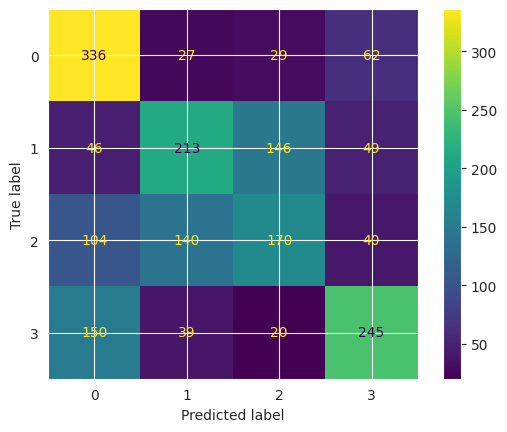

In [ ]:
# Crear y entrenar el modelo de regresión logística
model_logistic = LogisticRegression()
model_logistic.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo
predictions_logistic = model_logistic.predict(X_test_resampled)
print("Modelo de Regresión Logística - Accuracy:", accuracy_score(y_test_resampled, predictions_logistic))
print(classification_report(y_test_resampled, predictions_logistic))

#matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, predictions_logistic)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_logistic.classes_).plot()

Regresión logistica después de seleccionar con Random Forest

---



Modelo de Regresión Logística - Accuracy: 0.5302863436123348
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       454
           1       0.51      0.45      0.48       454
           2       0.46      0.36      0.41       454
           3       0.61      0.55      0.58       454

    accuracy                           0.53      1816
   macro avg       0.53      0.53      0.52      1816
weighted avg       0.53      0.53      0.52      1816



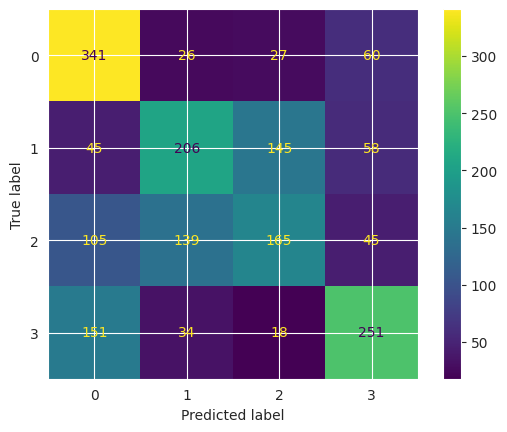

In [ ]:
# Crear y entrenar el modelo de regresión logística
model_logistic = LogisticRegression()
model_logistic.fit(X_train_selected, y_train_resampled)

# Evaluar el modelo
predictions_logistic = model_logistic.predict(X_test_selected)
print("Modelo de Regresión Logística - Accuracy:", accuracy_score(y_test_resampled, predictions_logistic))
print(classification_report(y_test_resampled, predictions_logistic))

#matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, predictions_logistic)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_logistic.classes_).plot()

Como podemos apreciar, el rendimiento de estos modelos es bastante deficiente incluso después del tratamiendo de los datos.

Al aplicar SMOTE, la precisión del modelo aumenta significativamente sin llegar a ser un modelo efectvo, especialmente se ve una gran mejoría en las clases poco representadas

Después, al seleccionar con Random Forest, vemos que practicamente no hay diferencia, esto sugiere que los atributos disponibles en el dataset no contienen información suficiente para ser relevantes el las predicciones del modelo.

---



Regresión logística con 'multinomial' para Softmax

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Modelo de Regresión Softmax - Accuracy: 0.5302863436123348
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       454
           1       0.51      0.45      0.48       454
           2       0.46      0.36      0.41       454
           3       0.61      0.55      0.58       454

    accuracy                           0.53      1816
   macro avg       0.53      0.53      0.52      1816
weighted avg       0.53      0.53      0.52      1816



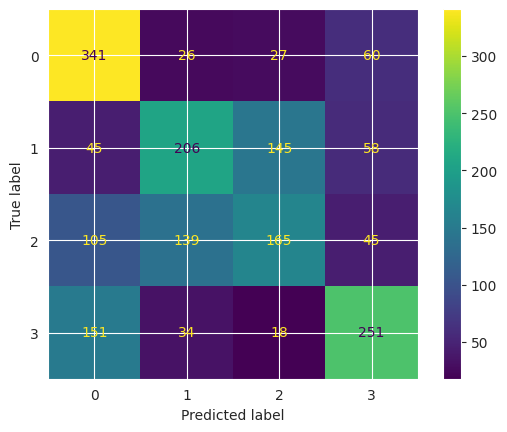

In [ ]:
# Usar la regresión logística con 'multinomial' para Softmax
model_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model_softmax.fit(X_train_selected, y_train_resampled)

# Evaluar el modelo
predictions_softmax = model_softmax.predict(X_test_selected)
print("Modelo de Regresión Softmax - Accuracy:", accuracy_score(y_test_resampled, predictions_softmax))
print(classification_report(y_test_resampled, predictions_softmax))

#matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, predictions_logistic)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_logistic.classes_).plot()

Como se puede apreciar, aun con softmax los resultados son practicamente identicos, esto nos está indicando que los datos no tienen la relevancia suficiente el desarrollo del modelo ML deseado.

# ÁRBOLES DE DECISIÓN 🌳

Utilizamos un modelo estandar sin variar parametros para obesrvar los resultados.

Empezamos utlizando los datos de entrenamiento sin procesar

Modelo de Árbol de Decisión - Accuracy: 0.4556701030927835
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        89
           1       0.53      0.52      0.53       454
           2       0.43      0.46      0.45       333
           3       0.28      0.28      0.28        94

    accuracy                           0.46       970
   macro avg       0.40      0.39      0.39       970
weighted avg       0.46      0.46      0.46       970



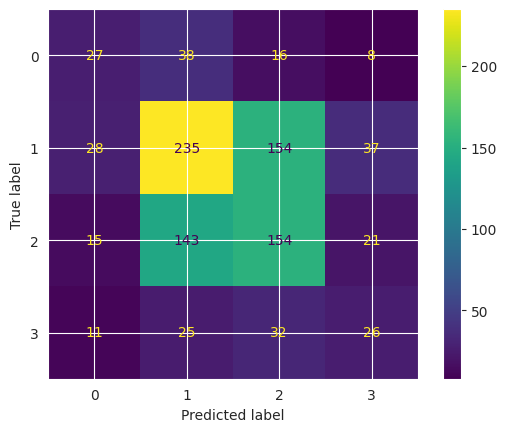

In [ ]:
# Crear una instancia del clasificador de árbol de decisión
model_tree = DecisionTreeClassifier()

# Entrenar el modelo con los datos de entrenamiento
model_tree.fit(X_train, y_train)

# Predecir las etiquetas para los datos de prueba
predictions_tree = model_tree.predict(X_test)

# Calcular la precisión del modelo
print("Modelo de Árbol de Decisión - Accuracy:", accuracy_score(y_test, predictions_tree))
print(classification_report(y_test, predictions_tree))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, predictions_tree)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_tree.classes_).plot()

Ahora con los datos procesados

Modelo de Árbol de Decisión - Accuracy: 0.4944933920704846
              precision    recall  f1-score   support

           0       0.50      0.70      0.58       454
           1       0.48      0.40      0.44       454
           2       0.48      0.37      0.42       454
           3       0.51      0.50      0.51       454

    accuracy                           0.49      1816
   macro avg       0.49      0.49      0.49      1816
weighted avg       0.49      0.49      0.49      1816



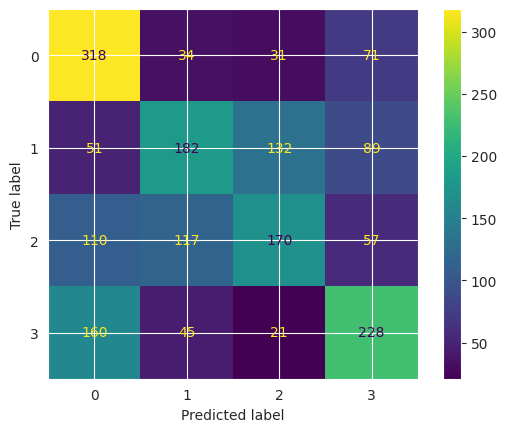

In [ ]:
# Crear una instancia del clasificador de árbol de decisión
model_tree = DecisionTreeClassifier()

# Entrenar el modelo con los datos de entrenamiento
model_tree.fit(X_train_selected, y_train_resampled)

# Predecir las etiquetas para los datos de prueba
predictions_tree = model_tree.predict(X_test_selected)

# Calcular la precisión del modelo
print("Modelo de Árbol de Decisión - Accuracy:", accuracy_score(y_test_resampled, predictions_tree))
print(classification_report(y_test_resampled, predictions_tree))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test_resampled, predictions_tree)
ConfusionMatrixDisplay(conf_matrix, display_labels=model_tree.classes_).plot()

Nuevamente, los resultados que enontramos son muy similares a los encontrados con los modelos anteriore

# RANDOM FOREST 🌳🌲🌲🌳

In [ ]:
# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=200, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test)

# Evaluar el modelo
print("Modelo de Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Modelo de Random Forest - Accuracy: 0.520618556701031
              precision    recall  f1-score   support

           0       0.71      0.22      0.34        89
           1       0.53      0.71      0.61       454
           2       0.49      0.45      0.47       333
           3       0.43      0.13      0.20        94

    accuracy                           0.52       970
   macro avg       0.54      0.38      0.40       970
weighted avg       0.52      0.52      0.50       970



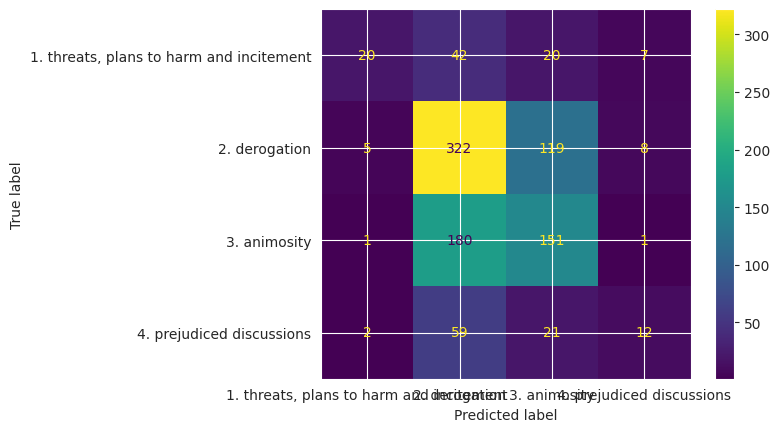

In [ ]:
# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

random forest tiene una presición similar a los modelos anteriores, probaremos ahora con los datos balanceados.

Modelo de Random Forest - Accuracy: 0.5324889867841409
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       454
           1       0.54      0.52      0.53       454
           2       0.49      0.38      0.43       454
           3       0.55      0.53      0.54       454

    accuracy                           0.53      1816
   macro avg       0.53      0.53      0.53      1816
weighted avg       0.53      0.53      0.53      1816



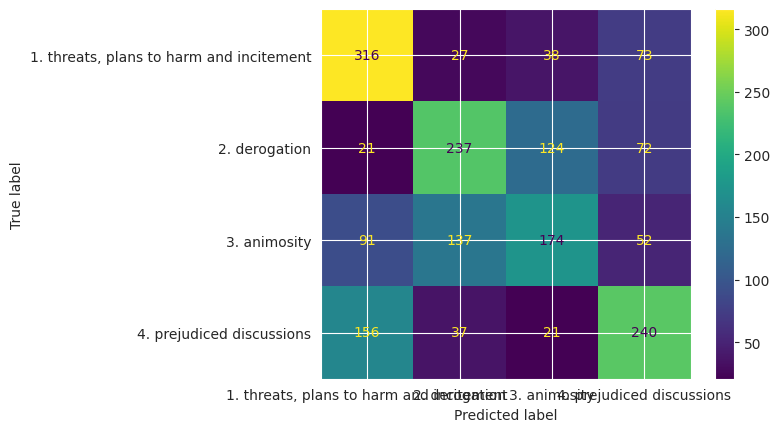

In [ ]:
# Entrenar el modelo de Random Forest
rf.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_resampled)

# Evaluar el modelo
print("Modelo de Random Forest - Accuracy:", accuracy_score(y_test_resampled, y_pred_rf))
print(classification_report(y_test_resampled, y_pred_rf))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test_resampled, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

Nuevamente, vemos una gran similitud a los modelos anteriores

Probando con n_estimators=300, min_samples_split=10.

Modelo de Random Forest - Accuracy: 0.5473568281938326
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       454
           1       0.53      0.57      0.55       454
           2       0.50      0.37      0.42       454
           3       0.59      0.55      0.57       454

    accuracy                           0.55      1816
   macro avg       0.55      0.55      0.54      1816
weighted avg       0.55      0.55      0.54      1816



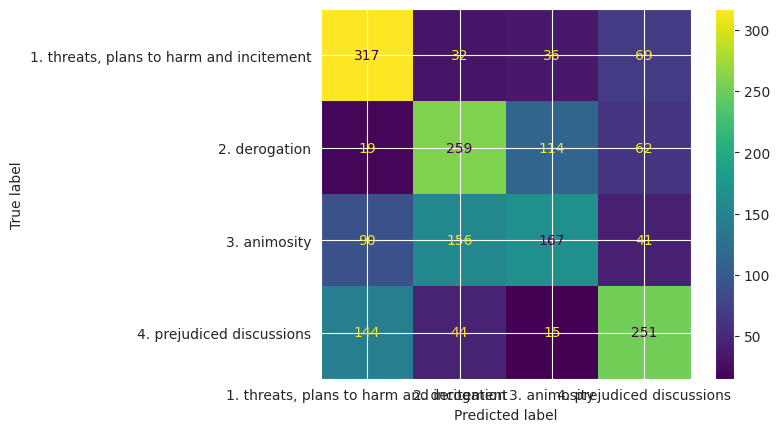

In [ ]:
# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=300, min_samples_split=10, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test_resampled)

# Evaluar el modelo
print("Modelo de Random Forest - Accuracy:", accuracy_score(y_test_resampled, y_pred_rf))
print(classification_report(y_test_resampled, y_pred_rf))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test_resampled, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

La presición del modelo aumento, lo que indica que ajustar estos parámetros tuvo un ligero impacto positivo.



Datos sin balancear: 52%

Datos balanceados: 53%

Variando parámetros: 54%

Balancear las clases mejoro el desempeño general del modelo, la variación de parámetros también ayudo a maximisar ligeramente la precisión del modelo.



# REDES NEURONALES 🕸 🧠

Caso base de la red neural, sin ninguna configuración y los datos procesados sin más.

Modelo de red neuronal - Accuracy: 0.4618556701030928
              precision    recall  f1-score   support

           0       0.38      0.28      0.32        89
           1       0.52      0.58      0.55       454
           2       0.41      0.41      0.41       333
           3       0.32      0.26      0.29        94

    accuracy                           0.46       970
   macro avg       0.41      0.38      0.39       970
weighted avg       0.45      0.46      0.46       970



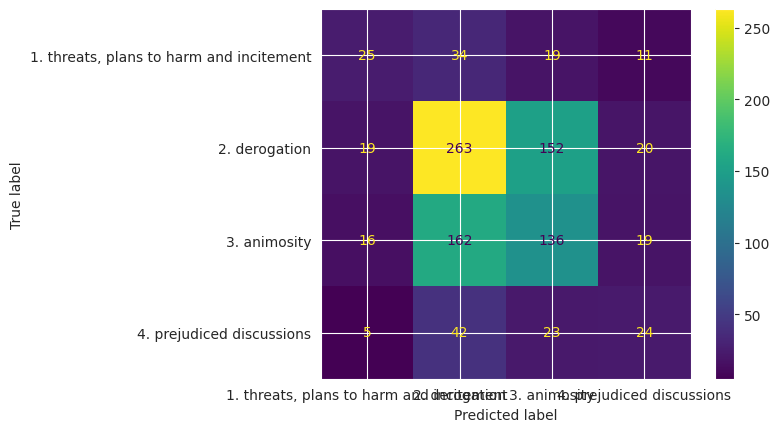

In [ ]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)


# Calcular la precisión del modelo
print("Modelo de red neuronal - Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

Caso #2 en este caso se usan los datos procesados con SMOTE además de parámetros modificados para poder observar el comportamiento de la red con más capas ocultas y un mayor número de iteraciones.

Modelo de red neuronal - Accuracy: 0.5319383259911894
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       454
           1       0.51      0.53      0.52       454
           2       0.45      0.37      0.40       454
           3       0.61      0.52      0.56       454

    accuracy                           0.53      1816
   macro avg       0.53      0.53      0.53      1816
weighted avg       0.53      0.53      0.53      1816



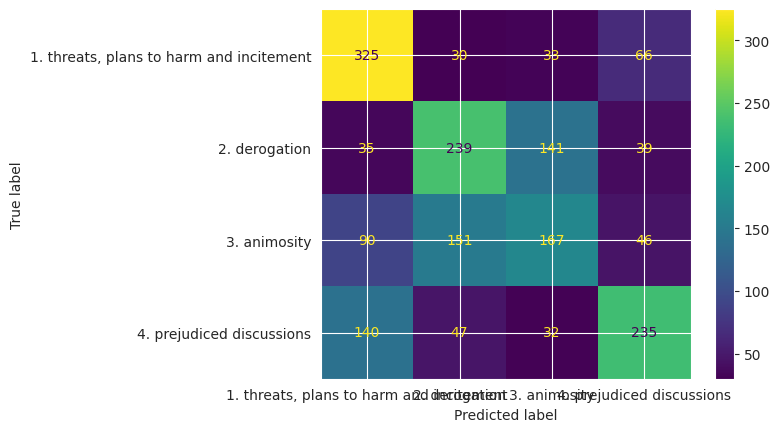

In [ ]:
clf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=500,
    random_state=42
)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test_resampled)
y_prob = clf.predict_proba(X_test_resampled)


# Calcular la precisión del modelo
print("Modelo de red neuronal - Accuracy:", accuracy_score(y_test_resampled, y_pred))
print(classification_report(y_test_resampled, y_pred))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test_resampled, y_pred)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

En este caso se usan los datos con random forest selection.

Modelo de red neuronal - Accuracy: 0.5154185022026432
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       454
           1       0.49      0.51      0.50       454
           2       0.41      0.36      0.38       454
           3       0.61      0.48      0.54       454

    accuracy                           0.52      1816
   macro avg       0.51      0.52      0.51      1816
weighted avg       0.51      0.52      0.51      1816



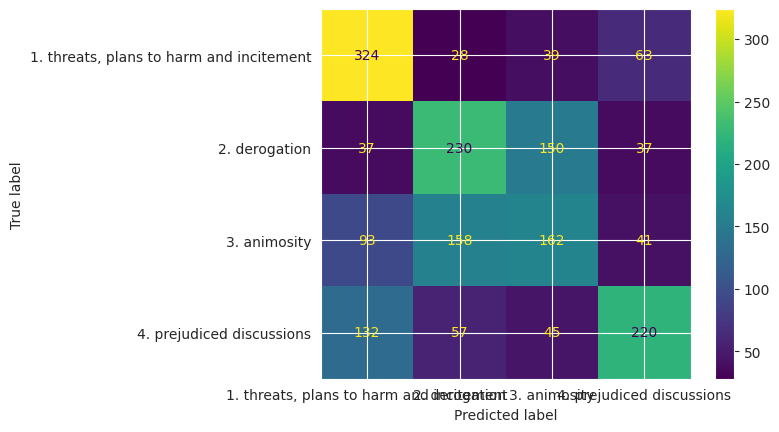

In [ ]:
clf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=500,
    random_state=42
)
clf.fit(X_train_selected, y_train_resampled)
y_pred = clf.predict(X_test_selected)
y_prob = clf.predict_proba(X_test_selected)


# Calcular la precisión del modelo
print("Modelo de red neuronal - Accuracy:", accuracy_score(y_test_resampled, y_pred))
print(classification_report(y_test_resampled, y_pred))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test_resampled, y_pred)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=label_encoder.classes_).plot()
plt.show()

Podemos observar los diferentes accuracy de la red neural con distintos parámetros y datos procesados de diferente manera. Con los accuracy:
1. 46%
2. 53%
3. 51%

Vemos que la red neuronal con los datos sin más y sin varias los parámetros es la que tiene un menor rendimiento y acierta menos si nos fijamos en las matrices de confusión, esto es así puesto que nuestro dataset además de estar desbalanceado tiene valores de texto lo que lleva a que sea necesario aplicar estrategias adicionales que mejores al modelo y puedan hacerlo trabajar mejor como quedo demostrado al usar SMOTE con parámetros de la red neuronal cambiados.

# RESULTADOS OBTENIDOS 📁

Análisis de resultados y recomendaciones

Después de implementar y evaluar varios modelos de Machine Learning, incluidos algoritmos tradicionales como Random Forest y redes neuronales (MLPClassifier), se observó una alta similitud en los resultados obtenidos. Esto indica que los datos, o la metodología empleada para su clasificación, no son adecuados para predecir con precisión a qué categoría pertenece un comentario sexista.

Este resultado no es del todo sorprendente, ya que desde la descripción del dataset en Kaggle se enfatiza que su objetivo principal es clasificar si un comentario es sexista o no. La mayoría de las muestras disponibles corresponden a comentarios no sexistas, lo que genera un desequilibrio significativo en las clases y dificulta la diferenciación entre las categorías sexistas.

Conclusiones:

Datos insuficientes para clasificaciones detalladas: La limitada cantidad de datos sexistas hace que los modelos no logren aprender patrones representativos para cada categoría.
Etiquetas poco diferenciadas: Las categorías actuales no parecen ser suficientemente claras o específicas, lo que puede confundir tanto al modelo como a los usuarios encargados de etiquetar los datos.
Recomendaciones:

1.  Recolección de nuevos datos: Es fundamental recopilar una mayor cantidad de comentarios sexistas, con una representación equilibrada de cada categoría. Este esfuerzo garantizará que el modelo tenga suficiente información para identificar patrones relevantes.

2.  Refinamiento de las categorías: Se sugiere explorar nuevas maneras de clasificar los datos, utilizando etiquetas más precisas y diferenciadas. Esto puede implicar realizar estudios previos con expertos en lenguaje o en género para definir criterios más objetivos y menos ambiguos.
Ampliación del dataset: Para mejorar la representatividad, considerar fuentes adicionales de comentarios, asegurándose de incluir contextos y plataformas diversas.
3.  Enriquecimiento de los datos: Aplicar técnicas de procesamiento de lenguaje natural (NLP) para agregar metadatos útiles, como análisis de sentimiento, contexto lingüístico, y relaciones semánticas entre las palabras.



Futuro del proyecto: Para que el modelo cumpla con los objetivos planteados, es imprescindible abordar estas limitaciones en los datos. Solo con un dataset bien estructurado, balanceado y con etiquetas claras será posible desarrollar un modelo predictivo eficaz que clasifique correctamente las categorías de comentarios sexistas.


# REFERENCIAS BIBLIOGRÁFICAS 📑

1. https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts/data
2. https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPClassifier.html
3.